# 1-2,图片数据建模流程范例

In [2]:
import os

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 


In [ ]:
!pip install torchvison==0.15.2
!pip install torchmetrics 

In [19]:
import torch 
import torchvision 
import torchkeras 
print("torch.__version__ = ", torch.__version__)
print("torchvision.__version__ = ", torchvision.__version__) 
print("torchkeras.__version__ = ", torchkeras.__version__) 
print("torchmetrics.__version__ = ", torchmetrics.__version__) 

torch.__version__ =  2.0.1
torchvision.__version__ =  0.15.2
torchkeras.__version__ =  3.9.3
torchmetrics.__version__ =  0.11.0


<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


### 一，准备数据

cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。

训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。

cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。

我们准备的Cifar2数据集的文件结构如下所示。

![](./data/cifar2.jpg)

在Pytorch中构建图片数据管道通常有两种方法。

第一种是使用 torchvision中的datasets.ImageFolder来读取图片然后用 DataLoader来并行加载。

第二种是通过继承 torch.utils.data.Dataset 实现用户自定义读取逻辑然后用 DataLoader来并行加载。

第二种方法是读取用户自定义数据集的通用方法，既可以读取图片数据集，也可以读取文本数据集。

本篇我们介绍第一种方法。


In [3]:
import torch 
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms as T
from torchvision import datasets 

In [4]:
transform_img = T.Compose(
    [T.ToTensor()])

def transform_label(x):
    return torch.tensor([x]).float()


In [5]:
ds_train = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/train/",
            transform = transform_img,target_transform = transform_label)
ds_val = datasets.ImageFolder("./eat_pytorch_datasets/cifar2/test/",
            transform = transform_img,target_transform = transform_label)
print(ds_train.class_to_idx)


{'0_airplane': 0, '1_automobile': 1}


In [6]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True)
dl_val = DataLoader(ds_val,batch_size = 50,shuffle = False)


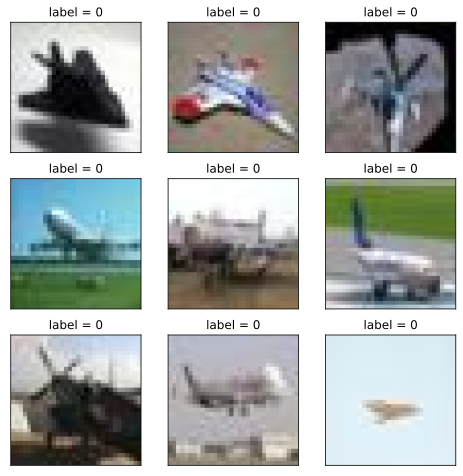

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()


![](./data/1-2-查看样本.png)

In [8]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height
for features,labels in dl_train:
    print(features.shape,labels.shape) 
    break
    

torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


### 二，定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择通过继承nn.Module基类构建自定义模型。

In [9]:
#测试AdaptiveMaxPool2d的效果
pool = nn.AdaptiveMaxPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape 

torch.Size([10, 8, 1, 1])

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x 
        
net = Net()
print(net)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)


In [11]:
import torchkeras
torchkeras.summary(net,input_data = features);

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 30, 30]                  896
MaxPool2d-2                         [-1, 32, 15, 15]                    0
Conv2d-3                            [-1, 64, 11, 11]               51,264
MaxPool2d-4                           [-1, 64, 5, 5]                    0
Dropout2d-5                           [-1, 64, 5, 5]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                    [-1, 1]                   33
Total params: 54,273
Trainable params: 54,273
Non-trainable params: 0
-----------------------------------------

### 三，训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种较通用的仿照Keras风格的函数形式的训练循环。

该训练循环的代码也是torchkeras库的核心代码。

torchkeras详情:  https://github.com/lyhue1991/torchkeras 


In [13]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class StepRunner:
    def __init__(self, net, loss_fn,
                 stage = "train", metrics_dict = None, 
                 optimizer = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer = optimizer
            
    def step(self, features, labels):
        #loss
        preds = self.net(features)
        loss = self.loss_fn(preds,labels)
        
        #backward()
        if self.optimizer is not None and self.stage=="train": 
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        return loss.item(),step_metrics
    
    def train_step(self,features,labels):
        self.net.train() #训练模式, dropout层发生作用
        return self.step(features,labels)
    
    @torch.no_grad()
    def eval_step(self,features,labels):
        self.net.eval() #预测模式, dropout层不发生作用
        return self.step(features,labels)
    
    def __call__(self,features,labels):
        if self.stage=="train":
            return self.train_step(features,labels) 
        else:
            return self.eval_step(features,labels)
        
class EpochRunner:
    def __init__(self,steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        
    def __call__(self,dataloader):
        total_loss,step = 0,0
        loop = tqdm(enumerate(dataloader),total =len(dataloader),file = sys.stdout)
        for i, batch in loop: 
            loss, step_metrics = self.steprunner(*batch)
            step_log = dict({self.stage+"_loss":loss},**step_metrics)
            total_loss += loss
            step+=1
            if i!=len(dataloader)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()}
                epoch_log = dict({self.stage+"_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log


def train_model(net, optimizer, loss_fn, metrics_dict, 
                train_data, val_data=None, 
                epochs=10, ckpt_path='checkpoint.pt',
                patience=5, monitor="val_loss", mode="min"):
    
    history = {}

    for epoch in range(1, epochs+1):
        printlog("Epoch {0} / {1}".format(epoch, epochs))

        # 1，train -------------------------------------------------  
        train_step_runner = StepRunner(net = net,stage="train",
                loss_fn = loss_fn,metrics_dict=deepcopy(metrics_dict),
                optimizer = optimizer)
        train_epoch_runner = EpochRunner(train_step_runner)
        train_metrics = train_epoch_runner(train_data)

        for name, metric in train_metrics.items():
            history[name] = history.get(name, []) + [metric]

        # 2，validate -------------------------------------------------
        if val_data:
            val_step_runner = StepRunner(net = net,stage="val",
                loss_fn = loss_fn,metrics_dict=deepcopy(metrics_dict))
            val_epoch_runner = EpochRunner(val_step_runner)
            with torch.no_grad():
                val_metrics = val_epoch_runner(val_data)
            val_metrics["epoch"] = epoch
            for name, metric in val_metrics.items():
                history[name] = history.get(name, []) + [metric]

        # 3，early-stopping -------------------------------------------------
        arr_scores = history[monitor]
        best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
        if best_score_idx==len(arr_scores)-1:
            torch.save(net.state_dict(),ckpt_path)
            print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                 arr_scores[best_score_idx]),file=sys.stderr)
        if len(arr_scores)-best_score_idx>patience:
            print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                monitor,patience),file=sys.stderr)
            break 
        net.load_state_dict(torch.load(ckpt_path))

    return pd.DataFrame(history)


In [20]:
import torchmetrics 

class Accuracy(torchmetrics.Accuracy):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        
    def update(self, preds: torch.Tensor, targets: torch.Tensor):
        super().update(torch.sigmoid(preds),targets.long())
            
    def compute(self):
        return super().compute()
    
    
loss_fn = nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   
metrics_dict = {"acc":Accuracy(task='binary')}

dfhistory = train_model(net,
    optimizer,
    loss_fn,
    metrics_dict,
    train_data = dl_train,
    val_data= dl_val,
    epochs=10,
    patience=5,
    monitor="val_acc", 
    mode="max")



================================================================================2023-08-02 11:52:19
Epoch 1 / 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 56.70it/s, val_acc=0.777, val_loss=0.442]

<<<<<< reach best val_acc : 0.7774999737739563 >>>>>>




================================================================================2023-08-02 11:52:27
Epoch 2 / 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 71.84it/s, val_acc=0.878, val_loss=0.302]

================================================================================2023-08-02 11:52:34
Epoch 3 / 10



<<<<<< reach best val_acc : 0.8784999847412109 >>>>>>


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.77it/s, val_acc=0.905, val_loss=0.23]

================================================================================2023-08-02 11:52:41
Epoch 4 / 10



<<<<<< reach best val_acc : 0.9045000076293945 >>>>>>


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 74.00it/s, val_acc=0.91, val_loss=0.23]

<<<<<< reach best val_acc : 0.9100000262260437 >>>>>>




================================================================================2023-08-02 11:52:48
Epoch 5 / 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 74.86it/s, val_acc=0.898, val_loss=0.247]

================================================================================2023-08-02 11:52:54
Epoch 6 / 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 74.57it/s, val_acc=0.888, val_loss=0.269]

================================================================================2023-08-02 11:53:01
Epoch 7 / 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 70.35it/s, val_acc=0.916, val_loss=0.204]

<<<<<< reach best val_acc : 0.9160000085830688 >>>>>>




================================================================================2023-08-02 11:53:08
Epoch 8 / 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.81it/s, val_acc=0.918, val_loss=0.213]

<<<<<< reach best val_acc : 0.9179999828338623 >>>>>>




================================================================================2023-08-02 11:53:14
Epoch 9 / 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 72.63it/s, val_acc=0.916, val_loss=0.211]

================================================================================2023-08-02 11:53:21
Epoch 10 / 10

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 70.51it/s, val_acc=0.925, val_loss=0.207]


<<<<<< reach best val_acc : 0.9254999756813049 >>>>>>


### 四，评估模型

In [21]:
dfhistory 

,train_loss,train_acc,val_loss,val_acc,epoch
0,0.529700,0.7395,0.441578,0.7775,1
1,0.371428,0.8377,0.301706,0.8785,2
2,0.289571,0.8816,0.230052,0.9045,3
3,0.244945,0.9002,0.229661,0.9100,4
4,0.228657,0.9079,0.246743,0.8980,5
5,0.220191,0.9094,0.269375,0.8880,6
6,0.212987,0.9148,0.203596,0.9160,7
7,0.217182,0.9107,0.212565,0.9180,8
8,0.184843,0.9273,0.210720,0.9160,9
9,0.187024,0.9261,0.207067,0.9255,10


In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

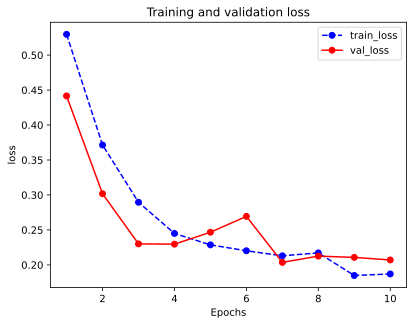

In [23]:
plot_metric(dfhistory,"loss")

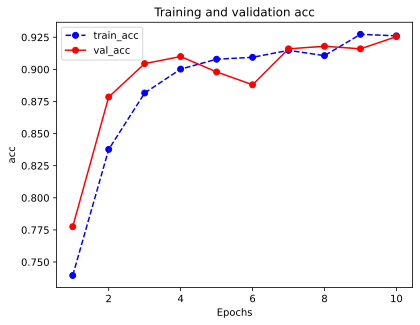

In [24]:
plot_metric(dfhistory,"acc")

### 五，使用模型

In [25]:
def predict(net,dl):
    net.eval()
    with torch.no_grad():
        result = nn.Sigmoid()(torch.cat([net.forward(t[0]) for t in dl]))
    return(result.data)

In [26]:
#预测概率
y_pred_probs = predict(net,dl_val)
y_pred_probs

tensor([[0.2046],
        [0.0154],
        [0.0424],
        ...,
        [0.9893],
        [0.9854],
        [0.4706]])

In [27]:
#预测类别
y_pred = torch.where(y_pred_probs>0.5,
        torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [0.]])

### 六，保存模型

推荐使用保存参数方式保存Pytorch模型。

In [28]:
print(net.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias'])


In [29]:
# 保存模型参数

torch.save(net.state_dict(), "./data/net_parameter.pt")

net_clone = Net()
net_clone.load_state_dict(torch.load("./data/net_parameter.pt"))

predict(net_clone,dl_val)

tensor([[0.2046],
        [0.0154],
        [0.0424],
        ...,
        [0.9893],
        [0.9854],
        [0.4706]])

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)
